<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S23_sorter_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gtsam

from gtbook.discrete import Variables
from gtbook.display import show

from IPython.display import display
from ipywidgets import interact

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtbook
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)

In [3]:
# Define variables here
Conductivity = VARIABLES.binary("Conductivity")
Detection = VARIABLES.discrete("Detection", ["bottle", "cardboard", "paper"])
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = VARIABLES.discrete("Category", categories) # Not an accident that it is defined last.

# Sensors for Sorting Trash

> Probability distributions can be used to model the behavior of sensors.


<img src="Figures2/S23-Trash_sorting_robot_with_gripper-07.jpg" alt="Splash image with robot that seems to be weighing buckets of trash" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

How can our trash sorting system know the category of an object that enters the sorting area? Robots use sensors to measure aspects of the world, and then make inferences about the world state based on these measurements. So, sensing can be used to infer the type of the object.

Let us assume our robot cell only has three sensors:
* a conductivity sensor, outputting the value `True` or `False`
* a camera with a three detection algorithms: bottle, cardboard, paper
* a scale, which gives a continuous value in kg.

We will discuss each in turn.

## Binary Sensors

> A binary sensor can be modeled using conditional probability distributions.

Sadly, sensors are imperfect devices. For example, consider a sensor that measures electrical conductivity. Suppose we have a binary sensor that simply returns `True` or `False` , based on a measurement from an electrical probe, for an object's conductivity.  For a metal can, this sensor will return `True` almost every time; however, some cans may be a bit dirty, or the probe may not make good contact, and these can lead to a mis-classification, returning `False`.

Probability theory lets us quantify this. For example, for a metal can, the probability of the sensor returning `True` might be $0.9$, and hence the probability of returning `False` is $1-0.9=0.1$. 
Of course in reality, we cannot know the true values of these probabilities, but we can estimate them using statistics.
A straightforward approach is to merely perform a set of experiments, and construct
a histogram of the results.

Because the probability of the outcome depends on the type of the trash item, we represent this with a **Conditional Probability**, which accords a value 

$$P(conductive| trash~category)$$

to every possible outcome (only `True` or `False` for this example), and where the `|` indicates that this depends on the category of the trash item. For example, we already established that

$$P(conductive=True| trash~category=can)=0.9$$

$$P(conductive=False| trash~category=can)=0.1$$


## Conditional Probabilities

In general, the probability mass function of *any* single variable $X$ can be
parameterized by a parameter $Y$, whose value we assume as known. 
This corresponds to the notion of a conditional probability,
which we write as 

$$P(X|Y=y).$$

Note that given a particular value of
$Y$, this is just a probability distribution over $X$, with parameters given by a
PMF, as before. 

There are many ways to specify conditional probabilities, but in this simple case, with a binary outcome and a finite number of discrete categories, the simplest representation is to use a a **Conditional Probability Table** or CPT. 

An example is shown below for our binary sensor example, taking care to first create the variables for pretty-printing:

In [4]:
pCT = gtsam.DiscreteConditional(
    Conductivity, [Category], "99/1 99/1 10/90 15/85 95/5")
pretty(pCT)

Note the rows add up to 1.0, as each row is a valid probability mass function (PMF).


Conditional probability distributions are a great way to represent
knowledge about the world in robotics. In particular, we use them
to model sensors in this chapter.
In the next chapter, we will use them to model 
how we can affect the state of the robot by *actions*.

A complete **sensor model** specifies a (potentially giant) CPT for every
possible state. An observation $z$ can be rather impoverished, or very
detailed, and one can also envision modeling several different sensors
on the robot. In the latter case, we will be able to *fuse* the
information from multiple sensors.

Conditional probability tables do not *have* to be specified as giant
tables. In case we index the discrete states with semantically
meaningful indices.
For example, in later chapters we will represent a robot's workspace
as a grid, and the indices into the grid can serve this purpose.
In such cases, we can often specify the CPT in parametric form.

## Multi-Valued Sensors

Binary sensors are easily generalized to multi-valued sensors. For our running example, assume that there is a camera mounted in the work cell, looking down on the trash conveyor belt. The camera is connected to a computer which runs a vision algorithm that can output three possible detected classes: `bottle` , `cardboard` , and `paper`.
We can model this sensor using the conditional probability distribution

$$P(detection| trash~category)$$

 The CPT for this sensor now has three columns, and one plausible CPT is given in python code below:


In [5]:
pDT = gtsam.DiscreteConditional(
    Detection, [Category], "2/88/10 2/20/78 33/33/34 33/33/34 95/2/3")
pretty(pDT)


As you can tell, this detector is pretty good at detecting cardboard.
For example, 
we have $P(Detection = cardboard| Category = cardboard) = 0.88$. 
Incidentally, this means that our sensor still mis-classifies cardboard about 1 in 10 times, 12% to be exact, as $1-0.88 = .12$. Unfortunately, our "vision sensor" is not great when dealing with classes it does *not* know about, which is rather typical of this type of model. Hence, for a metal can, the sensor essentially outputs a class at random.


## Continuous Valued Sensors

Next we discuss continuous-valued sensors, like a *scale*, which measures an object's weight.
For our trash sorting system, it stands to reason that the weight of an object is a great indicator of what category it might belong to, but, how should we treat *continuous* measurements? 
We could use a very finely quantized histogram on some discretized weight scale, allowing us to use the `DiscreteConditional` machinery from above, but we can do much better by explicitly representing
weight as a continuous quantity. 
In particular, we will not  represent the probability distribution as a PMF, but will instead use a **probability density function (pdf)**.

We will have much more to say about continuous random variable's and pdf's later in the book, but for now we skip these details, and represent the conditional pdf for our weight sensor using the omnipresent "Bell Curve."
In particular, let us assume that we can fit a Gaussian curve to the data of a particular category. As a reminder, a Gaussian curve is defined as below:

In [6]:
def Gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)

We can easily plot this using plotly:

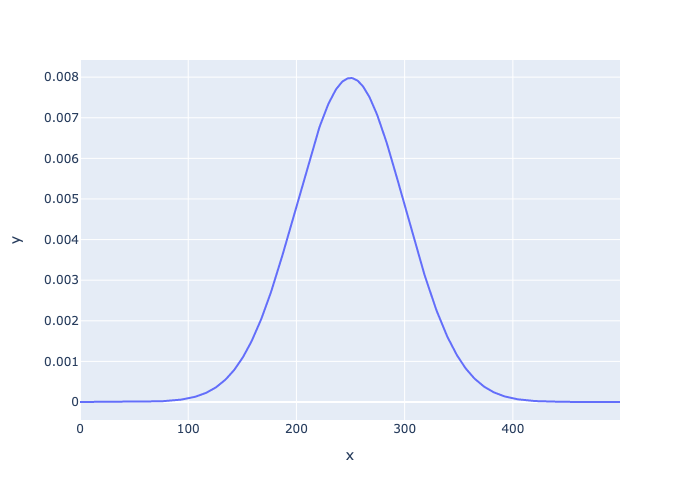

In [7]:
#| caption: a Gaussian distribution with mean 250 and standard deviation 50.
#| label: fig:gaussian
X = np.arange(0, 500)
px.line(x=X, y=Gaussian(X, mu=250, sigma=50))

Note that for any given continuous value, the probability is zero: we can only use the Gaussian as a *density*, integrating over a small (or large) continuous interval to obtain the probability of the value landing within that interval.

We denote a conditional **density** with a lowercase $p$ to indicate it is a density over a continuous quantity. The condition to the right of the bar is still a discrete category:

$$p(Weight|Category)$$


Let us assume that we fit a Gaussian to the weight of a sample of objects from every one of our 5 categories. We can represent the resulting mean and standard deviation (specified in in grams) any way we want, e.g., using a numpy array as below:

In [8]:
pWC = np.array([[20, 10], [5, 5], [15, 5], [150, 100], [300, 200]])
pWC

array([[ 20,  10],
       [  5,   5],
       [ 15,   5],
       [150, 100],
       [300, 200]])

You might not remember what the 5 categories were, so let's make a small interactive applet wherein we can change the category to see the resulting conditional density:

In [9]:
#| caption: The conditional density of weight given category.
#| label: fig:weight_density
@interact(Category=categories)
def plot_weight_density(Category="can"):
    index = categories.index(Category)
    display(px.line(x=X, y=Gaussian(X, *pWC[index])))

interactive(children=(Dropdown(description='Category', index=2, options=('cardboard', 'paper', 'can', 'scrap mâ€¦

## Simulation by Sampling

> Simulation can be implemented by sampling from both state and measurement.

We can sample from a conditional distribution $P(X|Y)$ by selecting the
appropriate PMF, depending on the value of $Y$, and proceeding as before
using a method known as **inverse transform sampling**.

To simulate our trash example for a single discrete sensor, we  sample in two steps. We first sample from the category prior $C$ (Section 2.1), and then sample from the conditional probability distribution $P(S|C)$. Sampling from a conditional probability distribution works exactly the same way as sampling from the category prior - via the cumulative distribution function. Here we will not belabor the details again, but just use the sample method in GTSAM:


In [10]:
category_prior = gtsam.DiscreteDistribution(Category, "200/300/250/200/50")
pretty(category_prior)

In [11]:
# sample from category
category = category_prior.sample()
print(f"category={category}")

# then sample from the discrete sensors
# TODO: single value
values = gtsam.DiscreteValues()
values[Category[0]] = category
print(f"conductivity = {pCT.sample(values)}")
print(f"detection = {pDT.sample(values)}")

category=0
conductivity = 0
detection = 2


Sampling from a continuous probability distribution is slightly more involved. For now, we will merely use numpy to sample from the continuous density $p(S|C)$:

In [12]:
# sample from Gaussian with `numpy.random.normal`
print(f"weight = {np.random.normal(*pWC[category])}")

weight = 13.367022785959453


## Simulating Multiple Sensors

> To simulate multiple sensors, we sample from the state, and then from each sensor.
The code to do this is as follows:

In [13]:
# Sample from state, then from all three sensors:
def sample():
    category = category_prior.sample()
    values = gtsam.DiscreteValues()
    values[Category[0]] = category
    conductivity = pCT.sample(category)
    detection = pDT.sample(category)
    weight = np.random.normal(*pWC[category])
    return category, conductivity, detection, weight

In [14]:
for _ in range(10):
    print(sample())

(1, 0, 1, 6.466999978013559)
(2, 1, 1, 17.42165090112751)
(2, 1, 2, 20.550087221787766)
(1, 0, 2, 10.03143948161786)
(1, 0, 2, 1.9731791993020624)
(0, 0, 1, 36.01619858439088)
(1, 0, 1, 14.843048905370305)
(1, 0, 2, -1.279893559656321)
(3, 1, 0, 185.0702110134971)
(1, 0, 2, 9.225698046368052)


## GTSAM 101

> The GTSAM concepts used in this section, explained.

### DiscreteConditional

Above we created an instance of the `gtsam.DiscreteConditional` class. As with any GTSAM class, you can type

```python
help(gtsam.DiscreteConditional)
```

to get documentation on its constructors and methods. In particular, we called the constructor

```python
 __init__(self: gtsam.DiscreteConditional, 
          key: Tuple[int, int], 
          parents: List[Tuple[int, int]], 
          spec: str) -> None
 ```

which expects *three* arguments (besides `self`, which you can ignore):
* `key`: A tuple (id, cardinality), saying which variable this conditional is on.
* `parents`: A *list* of tuples, specifying the variables behind the bar.
* `spec`: A string that specifies a CPT (remember: conditional probability table) which is given as a string of PMF specifications (numbers, separated by `/`), in turn separated by spaces. There should be as many PMFs as there are different assignments to the parents.

We have not actually used this before, but let's look at an example where there are *two* parents:

In [15]:
conditional = gtsam.DiscreteConditional(Category, [Conductivity, Detection], 
    "6/1/1/1/1 1/6/1/1/1 1/1/6/1/1 1/1/1/6/1 1/1/1/1/6 3/1/2/1/3")
pretty(conditional)

 As you can see above, we had to specify six PMF groups, because there are six combinations of conductivity and detection values. The PMF specifications are read in the order that you see in the table representation above. Since conductivity is mentioned first in the parent list, it varies the slowest. It is important to pay attention to disordering rent specifying conditional probability tables in this way.

We saw in Section 2.1 that GSM represents probability mass functions as decision trees. It should come as no surprise that GTSAM also represents discrete *conditional* distributions in this way, i.e., as decision trees with more than one level. For example, for the binary conductivity sensor we have:

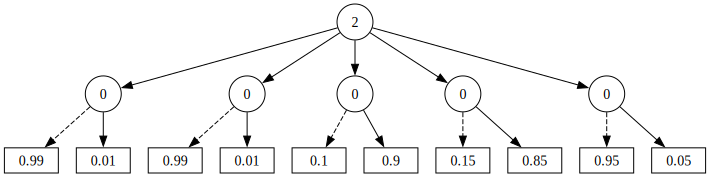

In [16]:
#| caption: Decision tree for the conditional distribution P(C|T).
#| label: fig:decision_tree
show(pCT)

Now each PMF on the conductivity, given the category, corresponds to a small "decision stump" at the lower level of the tree, where the two leaf probabilities always add up to 1.0.

For the three-valued sensor, we get the following decision tree:


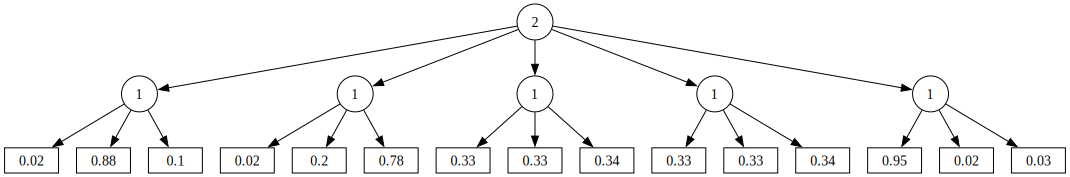

In [17]:
#| caption: Decision tree for the conditional distribution P(D|T).
#| label: fig:decision_tree_3
show(pDT)

Again, the decision between the 3 detections is made probabilistically at the stump level, but note a peculiar property of this sensor: for categories `can` and `scrap metal` (category indices 2 and 3, respectively) the probability is exactly $1/3$, *regardless* of the detection, so the stump is simply omitted.

### DiscreteValues

Above we also used the `DiscreteConditional.sample` method, which takes a single argument of type `gtsam.DiscreteValues`, specifying the actual values for the conditioning variables. Internally, this is implemented simply as a mapping from variable IDs (like `Category`) to values, represented as integers. 

We can create a `gtsam.DiscreteValues` instance by calling its default constructor, after which it behaves just like a Python dictionary:

In [21]:
values = gtsam.DiscreteValues()
pretty(values)

The key of the dictionary refers to the variable we want to assign a value to. It is an integer, if we want to assign a value to `Category`, which integer key should we use? We did this with the Variables object:

In [23]:
VARIABLES

The indices for the variables above are 0,1, and 2 respectively. So, we can just assign a value to the `Conductivity` variable using the index 0:

In [25]:
values[0] = 1
pretty(values)

Of course, we can also use the fact that the `Variables.discrete` method returns both the index and cardinality for the created variable, so that's a bit more readable:

In [46]:
id, cardinality = Category
values[id] = categories.index("scrap metal")
pretty(values)

Note that we can pretty-print it, which is nice. After creation, we can query it, again using the id:

In [47]:
print(values[id],
      f"which corresponds to '{categories[values[id]]}'")

3 which corresponds to 'scrap metal'


### Sampling

Why does `sample` take a `DiscreteValues`? Because, if we want to sample from a conditional distribution, for example $P(Detection|Category)$, we need to specify values for the conditioning variables!

In [51]:
for i in range(5):
    print(f"detection = {pDT.sample(values)}")

detection = 2
detection = 1
detection = 0
detection = 1
detection = 0


Check back earlier in this section to find the values for `pDT` and explain why you are seeing these values for "scrap metal". You could try modifying the `values` variable to assign a different variable to the trash category, and confirm that sample does indeed do the right thing.